# Hybrid WOFOST: Patching PCSE with Neural Leaf Dynamics

This notebook demonstrates how to create a Hybrid Crop Model by replacing a specific physical module (Leaf Dynamics) within the standard WOFOST 7.2 engine (`pcse.models.Wofost72_PP`) with a Neural Network surrogate.

We will use the **PCSE** (Python Crop Simulation Environment) engine structure, but we will "monkey patch" the `Leaf_Dynamics` class.

**The Workflow:**
1.  **Environment**: Setup `diffwofost` and `pcse`.
2.  **Data**: Download standard WOFOST 7.2 Potential Production test data (Wheat).
3.  **Ground Truth**: Run `Wofost72_PP` using the differentiable physical modules from `diffwofost` (specifically `WOFOST_Leaf_Dynamics`) to generate reference data.
4.  **Training**: Train a Neural Network to mimic the Leaf Dynamics (mapping Driving Variables -> Leaf State).
5.  **Hybrid Model**: Define a `NeuralLeafDynamics` class compatible with the PCSE API.
6.  **Simulation**: Run `Wofost72_PP` again, but this time patching the leaf module with our `NeuralLeafDynamics` class.
7.  **Analysis**: Compare the crop performance (Biomass, Yield) of the Hybrid model against the Physical baseline.

In [1]:
# 1. Imports and Setup
import sys
import copy
import urllib.request
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
import datetime
import yaml
from unittest.mock import patch

# PCSE imports
from pcse.models import Wofost72_PP
from pcse.base import ParameterProvider
from pcse.base.variablekiosk import VariableKiosk
from pcse.base.weather import WeatherDataContainer
from pcse.base import SimulationObject, StatesTemplate, RatesTemplate

# diffwofost imports (Physical implementations)
from diffwofost.physical_models.config import Configuration, ComputeConfig
from diffwofost.physical_models.crop.leaf_dynamics import WOFOST_Leaf_Dynamics
from diffwofost.physical_models.utils import prepare_engine_input, get_test_data

# Use CPU for this example
ComputeConfig.set_device('cpu')
warnings.filterwarnings("ignore", message="To copy construct from a tensor.*")

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# 2. Data Preparation
# Download official PCSE test data for WOFOST 7.2 Potential Production (Wheat)
url = "https://raw.githubusercontent.com/ajwdewit/pcse/refs/heads/master/tests/test_data/test_potentialproduction_wofost72_01.yaml"
filename = "test_potentialproduction_wofost72_01.yaml"

if not Path(filename).exists():
    urllib.request.urlretrieve(url, filename)
    print(f"Downloaded: {filename}")

# Load the data
# This helper function reads the YAML
test_data = get_test_data(filename)

# Extract components
# Note: prepare_engine_input is designed for diffwofost tests, but we can reuse parts of it
# or manually setup standard PCSE providers.
# We'll use standard PCSE ParameterProvider logic but using the dictionary from YAML.

crop_params = test_data["ModelParameters"]
site_params = test_data.get("SiteParameters", {}) # e.g. WAV, CO2
# Merge params
all_params = {}
all_params.update(crop_params)
all_params.update(site_params)

# Create ParameterProvider
# Note: WOFOST_Leaf_Dynamics expects parameters to be Tensors!
# We must convert float params to 0-d tensors for diffwofost modules to work.
param_provider = ParameterProvider(all_params)

# We need to forcefully override parameters to be Tensors because WOFOST_Leaf_Dynamics
# implementation specifically uses torch operations and checks .shape attribute which floats don't have.
# Standard PCSE ParameterProvider stores native types.
# diffwofost usually uses `prepare_engine_input` which wraps params.
# We will iterate and convert.
print("Converting parameters to Tensors for diffwofost compatibility...")
for key in all_params:
    val = all_params[key]
    if isinstance(val, (int, float)):
        # Convert scalar to 0-d tensor
        param_provider.set_override(key, torch.tensor(val, dtype=torch.float32))
    elif isinstance(val, list):
         # Convert list (tables) to tensor
        param_provider.set_override(key, torch.tensor(val, dtype=torch.float32))


# Create WeatherDataProvider
# The test data YAML contains 'WeatherVariables' (list of dicts).
# PCSE usually expects a provider. We can build a simple ListWeatherDataProvider or use the helper.
from pcse.base.weather import WeatherDataProvider
class SimpleWeatherDataProvider(WeatherDataProvider):
    def __init__(self, weather_list):
        super().__init__()
        self.store = {}
        for w in weather_list:
            day = w["DAY"]
            # Fix SNOWDEPTH NaN which causes PCSE validation error
            if "SNOWDEPTH" in w and np.isnan(w["SNOWDEPTH"]):
                w["SNOWDEPTH"] = 0.0
            
            wdc = WeatherDataContainer(**w)
            self.store[day] = wdc
    def __call__(self, day):
        # PCSE expects a WeatherDataContainer or similar object
        return self.store.get(day)

weather_provider = SimpleWeatherDataProvider(test_data["WeatherVariables"])
agro_management = test_data["AgroManagement"]

print("Data Providers initialized.")

Converting parameters to Tensors for diffwofost compatibility...
Data Providers initialized.


Running Reference Simulation with diffwofost.WOFOST_Leaf_Dynamics...
Reference simulation completed. Days: 260


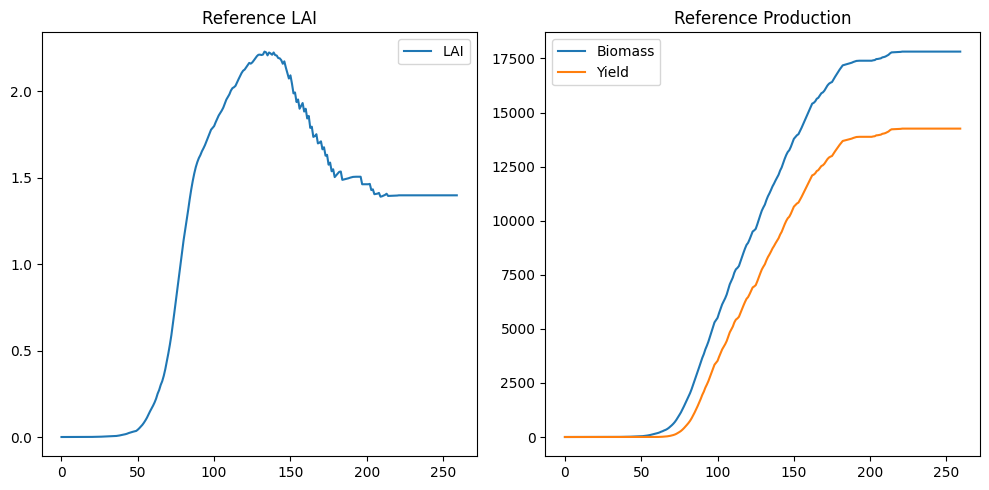

In [3]:
# 3. Generate Ground Truth (Reference Simulation)

# We want to run WOFOST72_PP but replace the Leaf_Dynamics module with the one from diffwofost.
# This ensures we are training against the exact physics implementation we want to emulate (PyTorch based),
# running inside the standard PCSE engine.

print("Running Reference Simulation with diffwofost.WOFOST_Leaf_Dynamics...")

# Patch the class in the module where Wofost72_PP is defined/imports it.
# Wofost72_PP imports Leaf_Dynamics from pcse.crop.wofost72
with patch("pcse.crop.wofost72.Leaf_Dynamics", WOFOST_Leaf_Dynamics):
    # Initialize model
    wofost_ref = Wofost72_PP(param_provider, weather_provider, agro_management)
    
    # Run
    wofost_ref.run_till_terminate()
    
    # Get output
    reference_results = wofost_ref.get_output()

print(f"Reference simulation completed. Days: {len(reference_results)}")

# Visualize Reference
days = range(len(reference_results))
lai_ref = [r["LAI"] for r in reference_results]
twlv_ref = [r["TWLV"] for r in reference_results]
tagp_ref = [r["TAGP"] for r in reference_results]
twso_ref = [r["TWSO"] for r in reference_results]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(days, lai_ref, label="LAI")
plt.title("Reference LAI")
plt.legend()
plt.subplot(1,2,2)
plt.plot(days, tagp_ref, label="Biomass")
plt.plot(days, twso_ref, label="Yield")
plt.title("Reference Production")
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
# 4. Prepare Data for Neural Network Training

# We need inputs (Driving Variables) and Output targets (LAI, TWLV) for the neural network.
# The `diffwofost` Leaf Dynamics module uses:
# Inputs: DVS, FL, ADMI, RFTRA, SAI, PAI, TEMP, and previous state (LAI, TWLV).
# Unlike the previous example, we can't easily access the internal 'driving variables' calculated inside WOFOST
# unless we output them.
# Fortunately, Wofost72_PP output usually contains DVS, TAGP.
# We might need to approximate or derive some inputs if they aren't standard outputs.
# Inputs needed:
# - DVS (Available)
# - FL (Fraction Leaves - depends on DVS, can be looked up from params)
# - ADMI (Assimilation Dry Matter Increase - NOT usually in output, likely need to derive or instrument model)
# - TEMP (From weather)

# To get exact inputs seen by the leaf module, the cleanest way is to instrument the Simulation or reuse the data structure.
# Let's re-run the reference simulation but hook into it to save the inputs passed to Leaf_Dynamics?
# Or simply calculate them using the same tables (tables are static functions of DVS).

# Helper to look up table values
def lookup_afgen(table_list, x_val):
    # simple linear interpolation for a list [x, y, x, y...]
    x = table_list[0::2]
    y = table_list[1::2]
    return np.interp(x_val, x, y)

# Construct Training Data
X_train = []
Y_train = []

prev_lai = 0.0
prev_twlv = 0.0

# Iterate through results to reconstruct inputs
# Note: This is an approximation. Ideally we'd log exact inputs.
# But for demonstration, we derive `ADMI`.
# ADMI approx = Delta(TAGP) / (1 - FR)? Wait, TAGP includes everything.
# Delta(TWLV) = ADMI * FL - Death. 
# This is getting complicated. 
# Better Approach:
# The Reference Model `wofost_ref` is a `diffwofost` object (partially).
# But checking `wofost_ref.get_output()` only gives standard vars.
# Let's use the parameters to recalculate FL, FR.

param_fr = all_params["FRTB"] # Fraction Root
param_fl = all_params["FLTB"] # Fraction Leaf (of above ground?) No, partitioning tables work differently in versions.
# PCSE FLTB is Fraction of Shoot to Leaves.
# WOFOST 7.2: Partitioning to Roots (FR) first. Then Remainder (1-FR) to Shoot.
# Inside Shoot: FL (Leaves), FS (Stems), FO (Storage).

dates = [r["day"] for r in reference_results]

# We need ADMI (Assimilation Dry Matter Increase).
# We can estimate it from the growth of Total Dry Weight (including roots).
# But standard output doesn't give Total Total (inc roots).
# It gives TAGP (Above Ground) and TWSO, TWLV, TWST.
# TAGP = TWLV + TWST + TWSO.
# Delta(TAGP) approx = ADMI * (1 - FR).
# So ADMI approx = Delta(TAGP) / (1 - Interpolate(FR, DVS)).

for i in range(1, len(reference_results)):
    today = reference_results[i]
    yest = reference_results[i-1]
    
    dvs = yest["DVS"] # State at start of day
    temp = weather_provider(yest["day"]).TEMP
    
    # Calculate partitioning fractions
    fr = lookup_afgen(param_fr, dvs)
    fl_shoot = lookup_afgen(param_fl, dvs) # Fraction of shoot to leaves
    
    # Calculate Biomass Increase (Proxy for ADMI)
    # TAGP increase
    d_tagp = today["TAGP"] - yest["TAGP"]
    # If d_tagp is negative (decay), ADMI was likely 0 (assuming no growth in decay phase).
    if d_tagp < 0:
        d_tagp = 0
    
    # ADMI (Shoot growth) = d_tagp approx (ignoring death for a moment).
    # Actual ADMI = Growth + MaintResp? 
    # Let's simplify: Neural Net takes "Potential Growth Allocation" as input.
    # We use d_tagp as the "mass to be distributed to shoot".
    # Leaf receives: d_tagp * fl_shoot.
    
    # Input Vector: [DVS, TEMP, Shoot_Growth_Input, Current_LAI, Current_TWLV]
    inputs = [dvs, temp, d_tagp, yest["LAI"], yest["TWLV"]]
    
    # Target: [Next_LAI, Next_TWLV]
    targets = [today["LAI"], today["TWLV"]]
    
    X_train.append(inputs)
    Y_train.append(targets)

X_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_tensor = torch.tensor(Y_train, dtype=torch.float32)

print(f"Training data prepared. Samples: {len(X_train)}")
print("Inputs: DVS, TEMP, dTAGP, LAI_t, TWLV_t")
print("Targets: LAI_t+1, TWLV_t+1")

Training data prepared. Samples: 259
Inputs: DVS, TEMP, dTAGP, LAI_t, TWLV_t
Targets: LAI_t+1, TWLV_t+1


Training NN...
Epoch 0, Loss: 163.106216
Epoch 200, Loss: 0.034164
Epoch 400, Loss: 0.012348
Epoch 600, Loss: 0.012141
Epoch 800, Loss: 0.011953
Epoch 1000, Loss: 0.011813
Epoch 1200, Loss: 0.011563
Epoch 1400, Loss: 0.011337
Epoch 1600, Loss: 0.011121
Epoch 1800, Loss: 0.013098
Epoch 2000, Loss: 0.010550
Epoch 2200, Loss: 0.010663
Epoch 2400, Loss: 0.009909
Epoch 2600, Loss: 0.012804
Epoch 2800, Loss: 0.033276
Epoch 3000, Loss: 0.013630
Epoch 3200, Loss: 0.010676
Epoch 3400, Loss: 0.083387
Epoch 3600, Loss: 0.010035
Epoch 3800, Loss: 0.010320
Epoch 4000, Loss: 0.007716
Epoch 4200, Loss: 0.008267
Epoch 4400, Loss: 0.007063
Epoch 4600, Loss: 0.011559
Epoch 4800, Loss: 0.009219
Epoch 5000, Loss: 0.008411
Epoch 5200, Loss: 0.007938
Epoch 5400, Loss: 0.007159
Epoch 5600, Loss: 0.006488
Epoch 5800, Loss: 0.005824
Epoch 6000, Loss: 0.004904
Epoch 6200, Loss: 0.011319
Epoch 6400, Loss: 0.004613
Epoch 6600, Loss: 0.003218
Epoch 6800, Loss: 0.022148
Epoch 7000, Loss: 0.002712
Epoch 7200, Loss: 

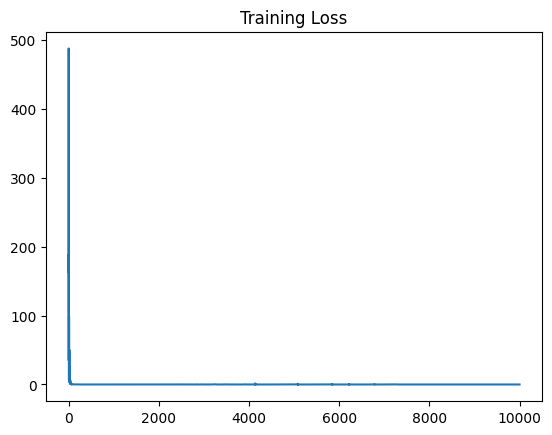

Neural Module defined.


In [5]:
# 5. Train Neural Network (Simulation Object)

from pcse.traitlets import Float, Int, Instance, Dict, List, Any

# Define the NN
class LeafStepNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Input: 5, Output: 2
        self.net = nn.Sequential(
            nn.Linear(5, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 2) # [LAI_next, TWLV_next]
        )
        
    def forward(self, x):
        return self.net(x)

# Training
model = LeafStepNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

print("Training NN...")
loss_hist = []  # Initialize loss history list
for epoch in range(10000):
    optimizer.zero_grad()
    preds = model(X_tensor)
    
    # Scale loss (TWLV is much larger than LAI)
    scale = torch.tensor([1.0, 1000.0])
    loss = loss_fn(preds/scale, Y_tensor/scale)
    
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.item()) # Append loss to history
    
    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

print("Training complete.")

plt.plot(loss_hist) # Plot loss history
plt.title("Training Loss")
plt.show()

# --- Wrapper for PCSE ---
# This class must mimic the interface of a PCSE SimulationObject (like WOFOST_Leaf_Dynamics)
class NeuralLeafDynamics(SimulationObject):
    # PCSE SimulationObject requires attributes to be defined as traitlets
    fr_table = Any()
    fl_table = Any()
    tdwi = Float()
    # lookup is a function, Any works
    lookup = Any()
    
    def __init__(self, day, kiosk, parvalues):
        pass # Attributes handled by traitlets
        super().__init__(day, kiosk, parvalues)

    def initialize(self, day, kiosk, parvalues):
        # Called by SimulationObject.__init__
        self.kiosk = kiosk
        print(f"DEBUG: NeuralLeafDynamics initialized. Kiosk ID: {id(self.kiosk)}")
        
        # Register variables we publish
        try:
             self.kiosk.register_variable(id(self), "LAI", type="S", publish=True)
             self.kiosk.register_variable(id(self), "TWLV", type="S", publish=True)
             self.kiosk.register_variable(id(self), "WLV", type="S", publish=True)
             self.kiosk.register_variable(id(self), "DWLV", type="S", publish=True)
        except Exception as e:
             # If re-running, check if we own it
             print(f"DEBUG Warning: Register failed (maybe duplicate?): {e}")

        # Parameters 
        fr_val = parvalues["FRTB"]
        if isinstance(fr_val, torch.Tensor): fr_val = fr_val.tolist()
        self.fr_table = fr_val
        
        fl_val = parvalues["FLTB"]
        if isinstance(fl_val, torch.Tensor): fl_val = fl_val.tolist()
        self.fl_table = fl_val

        tdwi_val = parvalues["TDWI"]
        if isinstance(tdwi_val, torch.Tensor): tdwi_val = tdwi_val.item()
        self.tdwi = tdwi_val
        
        self.lookup = lambda t, x: float(np.interp(x, t[0::2], t[1::2]))
        
        # Initial State Calculation
        fr = self.lookup(self.fr_table, 0.0)
        fl = self.lookup(self.fl_table, 0.0)
        wlv = self.tdwi * (1.0 - fr) * fl
        
        # publish initial values using set_variable
        self.kiosk.set_variable(id(self), "LAI", 0.0) 
        self.kiosk.set_variable(id(self), "TWLV", wlv)
        self.kiosk.set_variable(id(self), "WLV", wlv)
        self.kiosk.set_variable(id(self), "DWLV", 0.0)

        print(f"DEBUG: Set initial values. LAI in kiosk? {'LAI' in self.kiosk}")


    def calc_rates(self, day, drv):
        pass

    def integrate(self, day, delt):
        # Update states
        # Inputs: DVS, TEMP, dTAGP, LAI_t, TWLV_t
        dvs = self.kiosk.get("DVS", 0.0)
        temp = self.kiosk.get("TEMP", 10.0)
        dmi = self.kiosk.get("DMI", 0.0) 
        
        fr = self.lookup(self.fr_table, dvs)
        # fl_shoot = self.lookup(self.fl_table, dvs) 
        admi = dmi * (1.0 - fr)
        
        current_lai = self.kiosk.get("LAI")
        current_twlv = self.kiosk.get("TWLV")
        
        # Run NN for delta
        val_inputs = torch.tensor([dvs, temp, admi, current_lai, current_twlv], dtype=torch.float32)
        
        with torch.no_grad():
            preds = model(val_inputs.unsqueeze(0))
            
        next_lai = preds[0,0].item()
        next_twlv = preds[0,1].item()
        
        if next_lai < 0: next_lai = 0
        if next_twlv < 0: next_twlv = 0
        
        # Update Kiosk
        self.kiosk.set_variable(id(self), "LAI", next_lai)
        self.kiosk.set_variable(id(self), "TWLV", next_twlv)
        self.kiosk.set_variable(id(self), "WLV", next_twlv)
        self.kiosk.set_variable(id(self), "DWLV", 0.0)

print("Neural Module defined.")

Running Hybrid Simulation (PCSE with Neural Leaf Dynamics)...
DEBUG: NeuralLeafDynamics Initialized. LAI=0.0007, WLV=0.3468
Starting hybrid execution...
Hybrid simulation completed. Days: 260


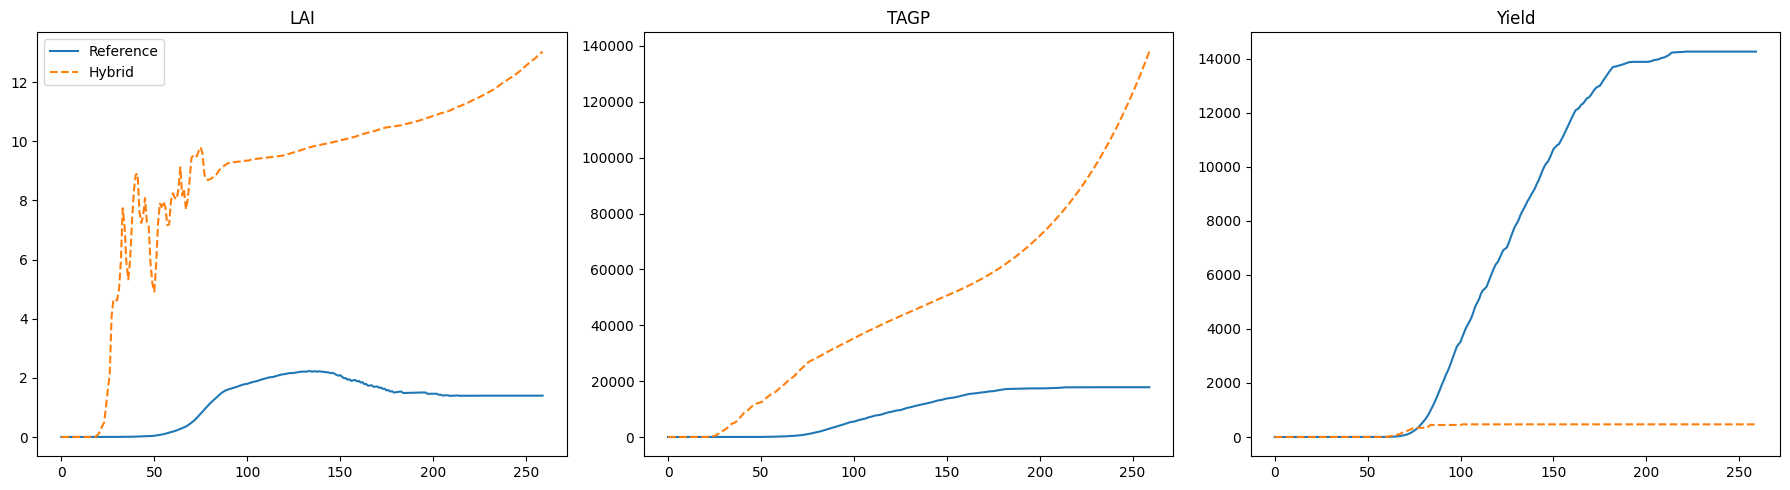

In [6]:
# 6. Run Hybrid Simulation (Validation)
import torch
import numpy as np
import matplotlib.pyplot as plt
from unittest.mock import patch
from pcse.base import SimulationObject, StatesTemplate, RatesTemplate
from pcse.traitlets import Float, Instance, Any
from pcse.models import Wofost72_PP

print("Running Hybrid Simulation (PCSE with Neural Leaf Dynamics)...")

class NeuralLeafDynamics(SimulationObject):
    """
    Hybrid Leaf Dynamics Component using a PyTorch Neural Network.
    Replacements standard PCSE Leaf_Dynamics.
    """
    
    # Internal Attributes (Must be traits in SimulationObject)
    fr_table = Any()
    fl_table = Any()
    _parvalues = Any()

    # State Variables (Managed by PCSE/Traits)
    class StateVariables(StatesTemplate):
        LAI = Float()
        TWLV = Float()  # Total Weight Living Leaves
        WLV = Float()   # Weight Living Leaves
        DWLV = Float()  # Dead Leaves
        
    # Rate Variables
    class RateVariables(RatesTemplate):
        GLAI = Float()
        GWLV = Float()
        GTWLV = Float()
        GDWLV = Float()

    def initialize(self, day, kiosk, parvalues):
        self._parvalues = parvalues # Store in trait
        self.kiosk = kiosk
        
        # 1. Calculate Initial Values FIRST
        self.fr_table = parvalues.get("FRTB", [])
        if isinstance(self.fr_table, torch.Tensor): self.fr_table = self.fr_table.tolist()
        self.fl_table = parvalues.get("FLTB", [])
        if isinstance(self.fl_table, torch.Tensor): self.fl_table = self.fl_table.tolist()
        
        tdwi = parvalues.get("TDWI", 50.0) 
        if hasattr(tdwi, "item"): tdwi = tdwi.item()
        
        # Simple lookup function for init
        def lookup(table, x):
             if not table: return 0.5
             t_x = table[0::2]
             t_y = table[1::2]
             return float(np.interp(x, t_x, t_y))
             
        # Calculate initial allocation
        fr = lookup(self.fr_table, 0.0)
        fl = lookup(self.fl_table, 0.0)
        
        initial_wlv = tdwi * (1.0 - fr) * fl
        
        laiem = parvalues.get("LAIEM", 0.0)
        if hasattr(laiem, "item"): laiem = laiem.item()
        
        if laiem > 0:
             initial_lai = laiem
        else:
             initial_lai = initial_wlv * 0.02 
        
        initial_dwlv = 0.0

        # 2. Instantiate States/Rates
        # Manual instantiation with initial values
        if self.states is None:
            state_vars = ["LAI", "TWLV", "WLV", "DWLV"]
            self.states = self.StateVariables(self.kiosk, publish=state_vars,
                                              LAI=initial_lai, TWLV=initial_wlv,
                                              WLV=initial_wlv, DWLV=initial_dwlv)
            
            rate_vars = ["GLAI", "GWLV", "GTWLV", "GDWLV"]
            self.rates = self.RateVariables(self.kiosk, publish=rate_vars)
        else:
            # If auto-instantiated, set values
            self.states.LAI = initial_lai
            self.states.TWLV = initial_wlv
            self.states.WLV = initial_wlv
            self.states.DWLV = initial_dwlv
        
        print(f"DEBUG: NeuralLeafDynamics Initialized. LAI={self.states.LAI:.4f}, WLV={self.states.WLV:.4f}")


    def calc_rates(self, day, drv):
        # 1. Gather Inputs
        dvs = self.kiosk.get("DVS", 0.0)
        temp = drv.TEMP
        gasst = self.kiosk.get("GASST", 0.0)
        mrest = self.kiosk.get("MREST", 0.0)
        fr = self.kiosk.get("FR", 0.0)
        
        # ADMI approx
        admi = (gasst - mrest) * (1.0 - fr)
        if admi < 0: admi = 0.0
        
        # 2. Neural Network Input
        current_lai = self.states.LAI
        current_twlv = self.states.TWLV
        
        # Check for NaN safety
        if np.isnan(current_lai): current_lai = 0.0
        if np.isnan(current_twlv): current_twlv = 0.0
        
        inp = torch.tensor([dvs, temp, admi, current_lai, current_twlv], dtype=torch.float32)
        
        # 3. Inference
        with torch.no_grad():
            preds = model(inp.unsqueeze(0))
            
        next_lai = preds[0,0].item()
        next_twlv = preds[0,1].item()
        
        # 4. Calculate Rates
        if next_lai < 0: next_lai = 0.0
        if next_twlv < 0: next_twlv = 0.0
        
        self.rates.GLAI = (next_lai - current_lai)
        self.rates.GWLV = (next_twlv - current_twlv)
        self.rates.GTWLV = self.rates.GWLV
        
        # Death Logic (Simple)
        if self.rates.GWLV < 0:
             self.rates.GDWLV = -self.rates.GWLV
        else:
             self.rates.GDWLV = 0.0
             
    def integrate(self, day, delt=1.0):
        # Apply Rates
        self.states.LAI += self.rates.GLAI * delt
        self.states.TWLV += self.rates.GTWLV * delt
        self.states.WLV += self.rates.GWLV * delt
        self.states.DWLV += self.rates.GDWLV * delt

# Run Simulation
target_patch = "pcse.crop.wofost72.Leaf_Dynamics"
try:
    with patch(target_patch, NeuralLeafDynamics):
        # Initialize
        wofost_hybrid = Wofost72_PP(param_provider, weather_provider, agro_management)
        
        print("Starting hybrid execution...")
        wofost_hybrid.run_till_terminate()
        
        hybrid_results = wofost_hybrid.get_output()

    print(f"Hybrid simulation completed. Days: {len(hybrid_results)}")
    
    # Visualization using global refs if available
    gl = globals()
    if 'lai_ref' in gl:
        days = range(len(gl['lai_ref']))
        hyb_days = range(len(hybrid_results))
        hyb_lai = [r["LAI"] for r in hybrid_results]
        hyb_tagp = [r["TAGP"] for r in hybrid_results]
        hyb_twso = [r["TWSO"] for r in hybrid_results]

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        axes[0].plot(days, gl['lai_ref'], label="Reference")
        axes[0].plot(hyb_days, hyb_lai, '--', label="Hybrid")
        axes[0].set_title("LAI")
        axes[0].legend()
        
        axes[1].plot(days, gl['tagp_ref'], label="Reference")
        axes[1].plot(hyb_days, hyb_tagp, '--', label="Hybrid")
        axes[1].set_title("TAGP")
        
        axes[2].plot(days, gl['twso_ref'], label="Reference")
        axes[2].plot(hyb_days, hyb_twso, '--', label="Hybrid")
        axes[2].set_title("Yield")
        
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"Simulation Failed: {e}")
    import traceback
    traceback.print_exc()

In [7]:
import pcse.base
print("pcse.base contents:", dir(pcse.base))

try:
    from pcse.base import StatesTemplate, RatesTemplate
    print("Found StatesTemplate, RatesTemplate in pcse.base")
except ImportError:
    print("Templates NOT in pcse.base")
    
import pcse.traitlets
print("pcse.traitlets contents:", dir(pcse.traitlets))

pcse.base contents: ['AncillaryObject', 'BaseEngine', 'ConfigurationLoader', 'DispatcherObject', 'MultiCropDataProvider', 'ParamTemplate', 'ParameterProvider', 'RatesTemplate', 'SimulationObject', 'StatesTemplate', 'StatesWithImplicitRatesTemplate', 'VariableKiosk', 'WeatherDataContainer', 'WeatherDataProvider', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'config_loader', 'dispatcher', 'engine', 'parameter_providers', 'simulationobject', 'states_rates', 'variablekiosk', 'weather']
Found StatesTemplate, RatesTemplate in pcse.base
pcse.traitlets contents: ['All', 'Any', 'BaseDescriptor', 'Bool', 'Bytes', 'CBool', 'CBytes', 'CComplex', 'CFloat', 'CInt', 'CLong', 'CRegExp', 'CUnicode', 'Callable', 'CaselessStrEnum', 'ClassBasedTraitType', 'Complex', 'Container', 'Dict', 'DottedObjectName', 'Enum', 'Float', 'ForwardDeclaredInstance', 'ForwardDeclaredType', 'FuzzyEnum', 'HasDescriptors', 'HasTraits', 'Instance', 'Int',